# **Imports**

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.random import set_seed
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.utils import plot_model
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
# setting plots style
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# **Data** **Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/df_train_processed.csv')
df_test = pd.read_csv('/content/drive/My Drive/df_test_processed.csv')

In [ ]:
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,1,M,158558,0.145081,9.150000e-07,...,0.155455,0.000000,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,1,M,160160,0.114319,7.137790e-07,...,0.163183,0.270133,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495
2,speech,neutral,normal,Dogs are sitting by the door,1st,1,M,156956,0.149963,9.554485e-07,...,0.190634,0.000000,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773
3,speech,neutral,normal,Dogs are sitting by the door,2nd,1,M,152152,0.139618,9.176213e-07,...,0.182551,0.205616,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871
4,speech,calm,normal,Kids are talking by the door,1st,1,M,169769,0.137665,8.108948e-07,...,0.177069,0.177847,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782


In [ ]:
df_test.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,frame_count,sum,mean,...,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,19,M,161762,0.475616,2.940224e-06,...,0.169929,0.222808,0.306697,0.466157,0.645931,0.789123,0.908316,1.0,-0.260279,-0.566556
1,speech,neutral,normal,Kids are talking by the door,2nd,19,M,155355,0.120148,7.733752e-07,...,0.216928,0.114567,0.170786,0.279347,0.557524,0.733053,0.866973,1.0,-0.428900,-0.587210
2,speech,neutral,normal,Dogs are sitting by the door,1st,19,M,160160,-0.599304,-3.741909e-06,...,0.227178,0.010295,0.023285,0.305395,0.577750,0.741576,0.889984,1.0,0.626916,-0.883317
3,speech,neutral,normal,Dogs are sitting by the door,2nd,19,M,158558,-0.080383,-5.069646e-07,...,0.179467,0.241405,0.368081,0.434591,0.620144,0.776419,0.904668,1.0,-0.825144,-0.383701
4,speech,calm,normal,Kids are talking by the door,1st,19,M,176176,0.152222,8.640319e-07,...,0.189124,0.217860,0.298851,0.393112,0.623309,0.772964,0.907035,1.0,-0.536669,-0.547354


In [ ]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [ ]:
# standardization (train)
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [ ]:
# standardization (test)
df_test_num = df_test.select_dtypes(include="number").drop("actor", axis=1)
df_test_cat = df_test.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_test_num_scaled = pd.DataFrame(scaler.fit_transform(df_test_num), columns=df_test_num.columns)
df_test = pd.concat([df_test_num_scaled, df_test_cat], axis=1)

In [ ]:
print(df_train.shape, df_test.shape)

(1828, 382) (624, 382)


# **Classification**

### **Methods**

In [ ]:
# function to create accuracy and loss plots
def plot_acc_loss(train_scores, val_scores, train_loss, val_loss):
  plt.plot(train_scores, label='TR')
  plt.plot(val_scores, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(train_loss, label='TR')
  plt.plot(val_loss, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
# function to transform continuous output from sigmoid into binary output

def get_pred_sigmoid(predictions):
  y_pred = np.zeros(len(predictions))
  for i in range(len(predictions)):
    if predictions[i] > .5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  return y_pred

In [ ]:
# function to select the index with max probability from softmax output

def get_pred_softmax(predictions):
  preds = [list(pred).index(max(pred)) for pred in predictions]
  return np.array(preds)

###**Target: Vocal Channel**

#### Data Preparation

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "song":
      new_array[i] = 1
  return new_array

In [ ]:
X_train = df_train.drop("vocal_channel", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["vocal_channel"])

In [ ]:
X_test = df_test.drop("vocal_channel", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["vocal_channel"])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [ ]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=10)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1828, 392) (1828,)
(366, 392) (366,)


####Model

In [ ]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))

    model.add(Dense(1,
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        seed=42,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'model__seed': random.sample(range(100), 10),
              'epochs': [10, 20, 50, 100, 200]

              }

search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(3, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score: 0.9808490703650093 
Best params {'model__seed': 1, 'model__n_hidden_units': 2, 'model__momentum': 0.01, 'model__learning_rate': 0.1, 'model__lambd': 0, 'epochs': 200}


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(1)

model = Sequential()
model.add(Dense(2, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 786       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 789
Trainable params: 789
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
46/46 [==============================] - 2s 7ms/step - loss: 0.6148 - accuracy: 0.5910 - val_loss: 0.5633 - val_accuracy: 0.5902
Epoch 2/200
46/46 [==============================] - 0s 3ms/step - loss: 0.5269 - accuracy: 0.6970 - val_loss: 0.4891 - val_accuracy: 0.7432
Epoch 3/200
46/46 [==============================] - 0s 3ms/step - loss: 0.4591 - accuracy: 0.8666 - val_loss: 0.4271 - val_accuracy: 0.9126
Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4043 - accuracy: 0.9282 - val_loss: 0.3777 - val_accuracy: 0.9426
Epoch 5/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3586 - accuracy: 0.9412 - val_loss: 0.3388 - val_accuracy: 0.9426
Epoch 6/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3228 - accuracy: 0.9419 - val_loss: 0.3069 - val_accuracy: 0.9508
Epoch 7/200
46/46 [==============================] - 0s 4ms/step - loss: 0.2910 - accuracy: 0.9596 - val_loss: 0.2760 - val_accuracy: 0.9590
Epoch 8/200
4

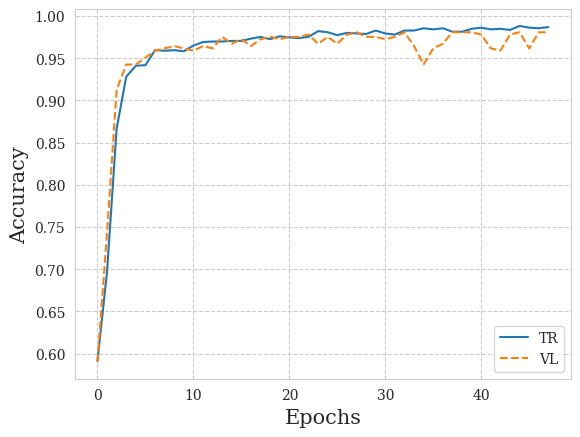

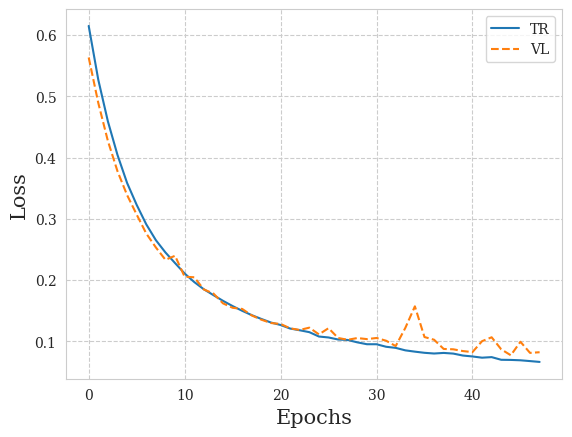

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       216
         1.0       0.97      0.99      0.98       150

    accuracy                           0.98       366
   macro avg       0.98      0.98      0.98       366
weighted avg       0.98      0.98      0.98       366



In [ ]:
keras.backend.clear_session()
tf.random.set_seed(1)

model = Sequential()
model.add(Dense(2, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 774       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________


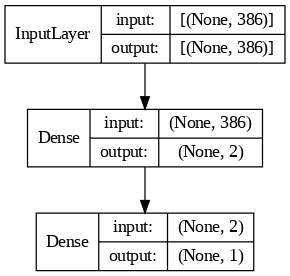

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    expand_nested=False,
    dpi=90,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
# retrain on all data (X_train)
history = model.fit(X_train, y_train, epochs=35, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 786       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 789
Trainable params: 789
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
58/58 [==============================] - 1s 4ms/step - loss: 0.6740 - accuracy: 0.5908
Epoch 2/35
58/58 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.5908
Epoch 3/35
58/58 [==============================] - 0s 4ms/step - loss: 0.5925 - accuracy: 0.5925
Epoch 4/35
58/58 [==============================] - 0s 3ms/step - loss: 0.5229 - accuracy: 0.7002
Epoch 5/35
58/58 [==============================] - 0s 3ms/ste

In [ ]:
# performance on test with train
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       360
         1.0       0.96      0.99      0.98       264

    accuracy                           0.98       624
   macro avg       0.98      0.98      0.98       624
weighted avg       0.98      0.98      0.98       624



20/20 [==============================] - 0s 1ms/step


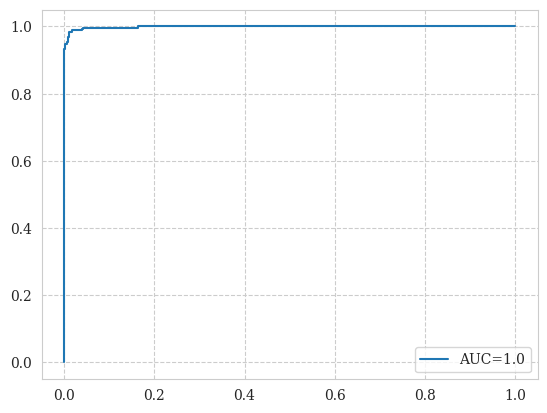

In [ ]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

In [ ]:
fpr_vocal_channel = fpr
tpr_vocal_channel = tpr
auc_vocal_channel = auc

In [ ]:
print(fpr_vocal_channel)

In [ ]:
print(tpr_vocal_channel)

[0.         0.00378788 0.93181818 0.93181818 0.9469697  0.9469697
 0.95454545 0.95454545 0.96969697 0.96969697 0.98484848 0.98484848
 0.98863636 0.98863636 0.99242424 0.99242424 0.99621212 0.99621212
 1.         1.        ]


In [ ]:
print(auc_vocal_channel)

0.998632154882155


#### Retraining on random weight initalizations

In [ ]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(2, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
    model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

    model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

    model.fit(X_train, y_train, epochs=35, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 4/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 5/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 6/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 7/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 9/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 10/10
20/20 [==============================] - 0s 1ms/step

Avg Accuracy: 0.9629807692307694 Std Accuracy: 0.01864010089230948
Avg Wt. F1: 0.9629257165769604 Std Wt. F1: 0.0186401008923094

###**Target: Sex**

#### Data Preparation

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [ ]:
X_train = df_train.drop("sex", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["sex"])

In [ ]:
X_test = df_test.drop("sex", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["sex"])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [ ]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=12)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 392) (1462,)
(366, 392) (366,)


####Model

In [ ]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))

    model.add(Dense(1,
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        seed=42,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'model__seed': random.sample(range(100), 10),
              'epochs': [10, 20, 50, 100, 200]

              }

search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(3, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score: 0.9801674128432132 
Best params {'model__seed': 97, 'model__n_hidden_units': 128, 'model__momentum': 0.001, 'model__learning_rate': 1, 'model__lambd': 0, 'epochs': 200}


In [ ]:
keras.backend.clear_session()
set_seed(97)

model = Sequential()
model.add(Dense(128, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
46/46 [==============================] - 2s 26ms/step - loss: 0.7725 - accuracy: 0.6224 - val_loss: 0.5403 - val_accuracy: 0.8443
Epoch 2/200
46/46 [==============================] - 0s 8ms/step - loss: 0.5058 - accuracy: 0.7763 - val_loss: 0.3268 - val_accuracy: 0.9153
Epoch 3/200
46/46 [==============================] - 0s 3ms/step - loss: 0.3778 - accuracy: 0.8386 - val_loss: 0.1757 - val_accuracy: 0.9481
Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.3262 - accuracy: 0.8707 - val_loss: 0.1380 - val_accuracy: 0.9399
Epoch 5/200
46/46 [==============================] - 0s 3ms/step - loss: 0.2282 - accuracy: 0.9097 - val_loss: 0.2087 - val_accuracy: 0.9208
Epoch 6/200
46/46 [==============================] - 0s 3ms/step - loss: 0.2252 - accuracy: 0.9097 - val_loss: 0.3669 - val_accuracy: 0.8279
Epoch 7/200
46/46 [==============================] - 0s 3ms/step - loss: 0.2322 - accuracy: 0.8940 - val_loss: 0.1291 - val_accuracy: 0.9699
Epoch 8/200


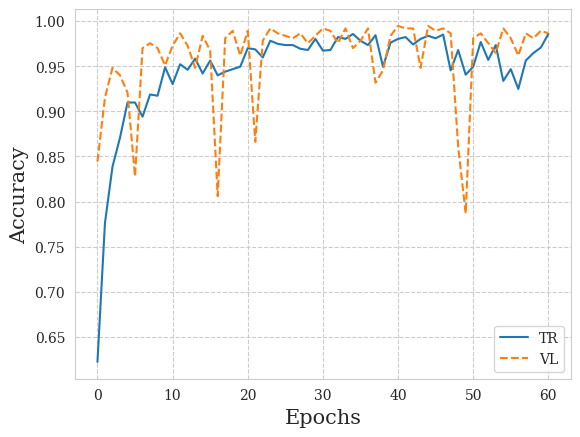

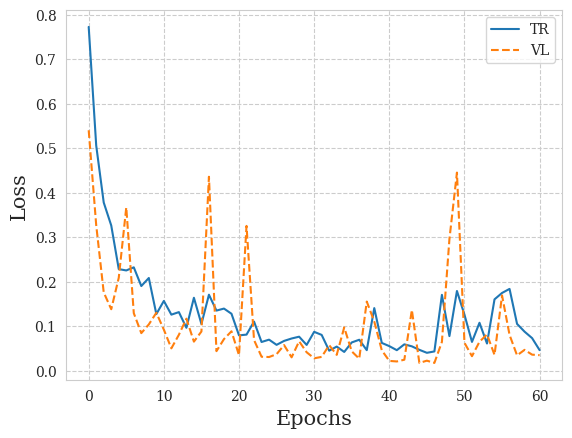

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       179
         1.0       1.00      0.97      0.99       187

    accuracy                           0.99       366
   macro avg       0.99      0.99      0.99       366
weighted avg       0.99      0.99      0.99       366



In [ ]:
# retrain on all data (X_train)

keras.backend.clear_session()
set_seed(97)

model = Sequential()
model.add(Dense(128, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=61, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/61
58/58 [==============================] - 1s 3ms/step - loss: 0.7608 - accuracy: 0.6395
Epoch 2/61
58/58 [==============================] - 0s 4ms/step - loss: 0.5054 - accuracy: 0.7954
Epoch 3/61
58/58 [==============================] - 0s 4ms/step - loss: 0.3289 - accuracy: 0.8545
Epoch 4/61
58/58 [==============================] - 0s 3ms/step - loss: 0.2455 - accuracy: 0.8972
Epoch 5/61
58/58 [==============================] - 0s 3

In [ ]:
# performance on test
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       312
         1.0       0.94      0.96      0.95       312

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



20/20 [==============================] - 0s 2ms/step


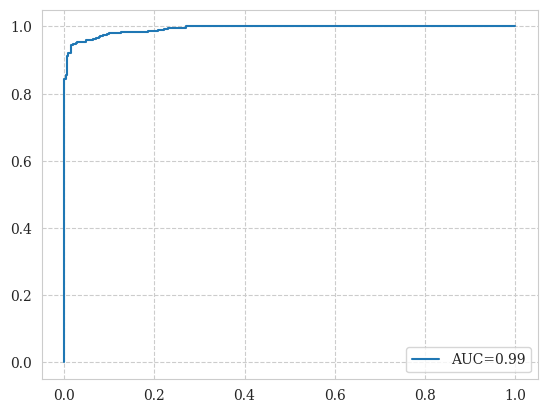

In [ ]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

In [ ]:
fpr_sex = fpr
tpr_sex = tpr
auc_sex = auc

In [ ]:
print(fpr_sex)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00320513
 0.00320513 0.00641026 0.00641026 0.00961538 0.00961538 0.01602564
 0.01602564 0.01923077 0.01923077 0.02564103 0.02564103 0.02884615
 0.02884615 0.04807692 0.04807692 0.06410256 0.06410256 0.07051282
 0.07051282 0.07692308 0.07692308 0.08012821 0.08012821 0.08653846
 0.08653846 0.09615385 0.09615385 0.09935897 0.09935897 0.125
 0.125      0.18589744 0.18589744 0.20833333 0.20833333 0.22115385
 0.22115385 0.23076923 0.23076923 0.26923077 0.26923077 1.        ]


In [ ]:
print(tpr_sex)

[0.         0.00320513 0.00961538 0.01602564 0.10897436 0.11538462
 0.17307692 0.17948718 0.21474359 0.22115385 0.22435897 0.23076923
 0.33974359 0.34615385 0.46794872 0.47435897 0.84294872 0.84294872
 0.85576923 0.85576923 0.91346154 0.91346154 0.91987179 0.91987179
 0.94551282 0.94551282 0.94871795 0.94871795 0.95192308 0.95192308
 0.95512821 0.95512821 0.95833333 0.95833333 0.96153846 0.96153846
 0.96474359 0.96474359 0.96794872 0.96794872 0.97115385 0.97115385
 0.97435897 0.97435897 0.9775641  0.9775641  0.98076923 0.98076923
 0.98397436 0.98397436 0.98717949 0.98717949 0.99038462 0.99038462
 0.99358974 0.99358974 0.99679487 0.99679487 1.         1.        ]


In [ ]:
print(auc_sex)

0.9929117357001973


In [ ]:
fpr_sex

NameError: ignored

#### Retraining on 10 random weight initalizations

In [ ]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(128, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
    model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

    model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.001),
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

    model.fit(X_train, y_train, epochs=61, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    print(i, acc, f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 1ms/step
23 0.9455128205128205 0.9455122607686223
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
99 0.9519230769230769 0.9519230769230769
Random weight initialization 3/10
20/20 [==============================] - 0s 1ms/step
17 0.9583333333333334 0.9583329052936522
Random weight initialization 4/10
20/20 [==============================] - 0s 2ms/step
41 0.9503205128205128 0.9503193645070075
Random weight initialization 5/10
20/20 [==============================] - 0s 1ms/step
74 0.9503205128205128 0.9503193645070075
Random weight initialization 6/10
20/20 [==============================] - 0s 1ms/step
56 0.9519230769230769 0.9519225830311375
Random weight initialization 7/10
20/20 [==============================] - 0s 1ms/step
53 0.9535256410256411 0.9535255216693418
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
4 0.9487179487179

###**Target: Emotional Intensity**

#### Data Preparation

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "strong":
      new_array[i] = 1
  return new_array

In [ ]:
X_train = df_train.drop("emotional_intensity", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
y_train = label_encoder(df_train["emotional_intensity"])

In [ ]:
X_test = df_test.drop("emotional_intensity", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
y_test = label_encoder(df_test["emotional_intensity"])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [ ]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=42)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1279, 392) (1279,)
(549, 392) (549,)


####I (1 layer, SGD)

In [ ]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))

    model.add(Dense(1,
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__momentum': [0, .001, .01, .1],
              'model__lambd': [0, .001, .01, .1],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(5, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score: 0.7560631127450981 
Best params {'model__seed': 3, 'model__n_hidden_units': 128, 'model__momentum': 0.01, 'model__learning_rate': 0.1, 'model__lambd': 0, 'epochs': 200}


In [ ]:
keras.backend.clear_session()
set_seed(3)

model = Sequential()
model.add(Dense(128, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 1s 10ms/step - loss: 0.6937 - accuracy: 0.5551 - val_loss: 0.6671 - val_accuracy: 0.5665
Epoch 2/200
40/40 [==============================] - 0s 5ms/step - loss: 0.6696 - accuracy: 0.5833 - val_loss: 0.6347 - val_accuracy: 0.6667
Epoch 3/200
40/40 [==============================] - 0s 5ms/step - loss: 0.6287 - accuracy: 0.6669 - val_loss: 0.6369 - val_accuracy: 0.5847
Epoch 4/200
40/40 [==============================] - 0s 5ms/step - loss: 0.6239 - accuracy: 0.6450 - val_loss: 0.5959 - val_accuracy: 0.7104
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 0.5977 - accuracy: 0.7005 - val_loss: 0.5891 - val_accuracy: 0.6903
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.6935 - val_loss: 0.5862 - val_accuracy: 0.6922
Epoch 7/200
40/40 [==============================] - 0s 5ms/step - loss: 0.5901 - accuracy: 0.6888 - val_loss: 0.6119 - val_accuracy: 0.6758
Epoch 8/200


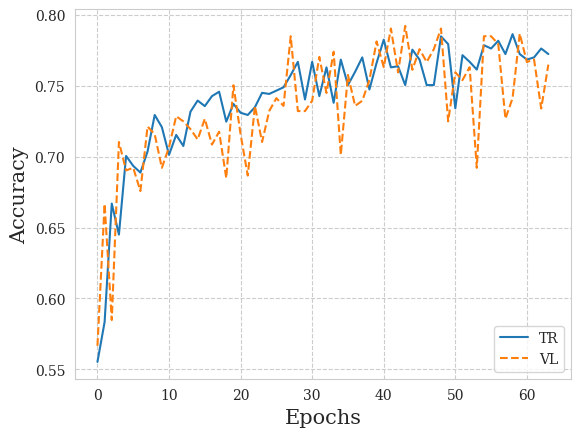

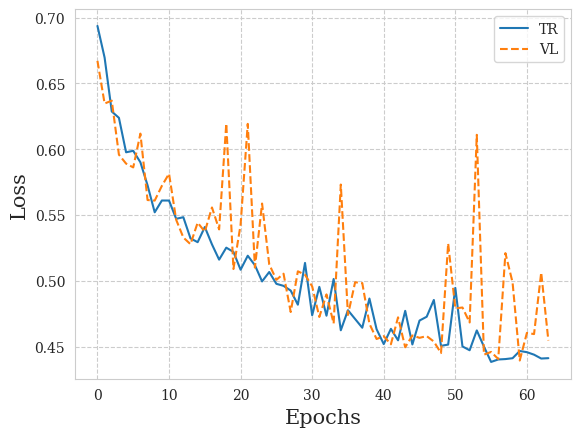

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.72      0.93      0.81       296
         1.0       0.87      0.57      0.69       253

    accuracy                           0.77       549
   macro avg       0.80      0.75      0.75       549
weighted avg       0.79      0.77      0.76       549



In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(3)

model = Sequential()
model.add(Dense(128, activation="sigmoid", input_dim = X_train.shape[1], kernel_regularizer=L2(0)))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=64, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/64
58/58 [==============================] - 1s 3ms/step - loss: 0.6892 - accuracy: 0.5410
Epoch 2/64
58/58 [==============================] - 0s 4ms/step - loss: 0.6596 - accuracy: 0.6078
Epoch 3/64
58/58 [==============================] - 0s 4ms/step - loss: 0.6154 - accuracy: 0.6679
Epoch 4/64
58/58 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.6761
Epoch 5/64
58/58 [==============================] - 0s 4

In [ ]:
# performance on test
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.53      0.67       336
         1.0       0.63      0.94      0.75       288

    accuracy                           0.72       624
   macro avg       0.77      0.73      0.71       624
weighted avg       0.78      0.72      0.71       624



20/20 [==============================] - 0s 1ms/step


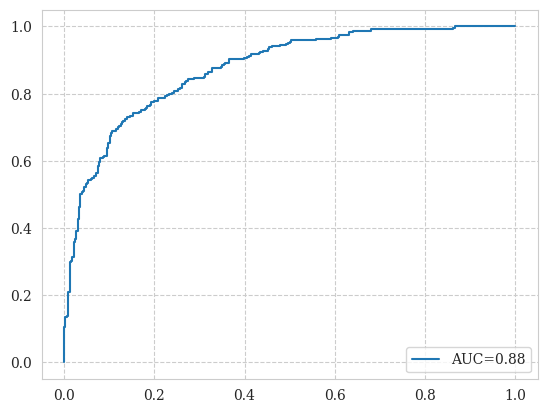

In [ ]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

####II (3 layers, Adam, Dropout)

In [ ]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units1, n_hidden_units2, hidden_activation, learning_rate, regularizer, initializer, output_activation, dropout_rate, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units1,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units2,
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "relu",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units1': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__dropout_rate': [.2, .4, .6, .8],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(3, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score: 0.7693410004654521 
Best params {'model__seed': 23, 'model__n_hidden_units2': 128, 'model__n_hidden_units1': 128, 'model__learning_rate': 0.01, 'model__dropout_rate': 0.2, 'epochs': 50}


In [ ]:
keras.backend.clear_session()
set_seed(23)
model = Sequential()
model.add(Dense(128,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,625
Trainable params: 58,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=62, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/62
40/40 [==============================] - 1s 9ms/step - loss: 0.6998 - accuracy: 0.5410 - val_loss: 0.6547 - val_accuracy: 0.6995
Epoch 2/62
40/40 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.6138 - val_loss: 0.6137 - val_accuracy: 0.6794
Epoch 3/62
40/40 [==============================] - 0s 5ms/step - loss: 0.6230 - accuracy: 0.6622 - val_loss: 0.5857 - val_accuracy: 0.6867
Epoch 4/62
40/40 [==============================] - 0s 4ms/step - loss: 0.5882 - accuracy: 0.6974 - val_loss: 0.5655 - val_accuracy: 0.7104
Epoch 5/62
40/40 [==============================] - 0s 5ms/step - loss: 0.5634 - accuracy: 0.7232 - val_loss: 0.5514 - val_accuracy: 0.7322
Epoch 6/62
40/40 [==============================] - 0s 5ms/step - loss: 0.5550 - accuracy: 0.7170 - val_loss: 0.5398 - val_accuracy: 0.7250
Epoch 7/62
40/40 [==============================] - 0s 5ms/step - loss: 0.5497 - accuracy: 0.7326 - val_loss: 0.5336 - val_accuracy: 0.7213
Epoch 8/62
40/40 [==

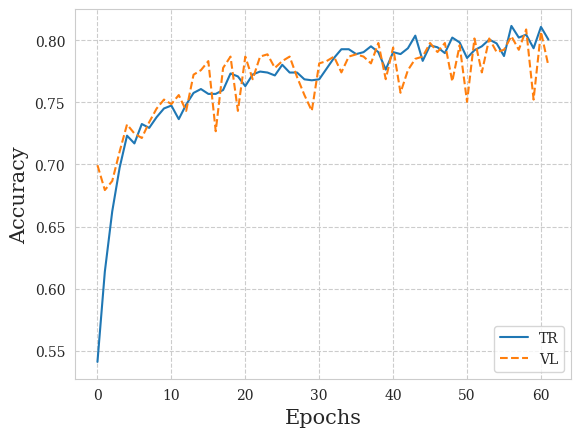

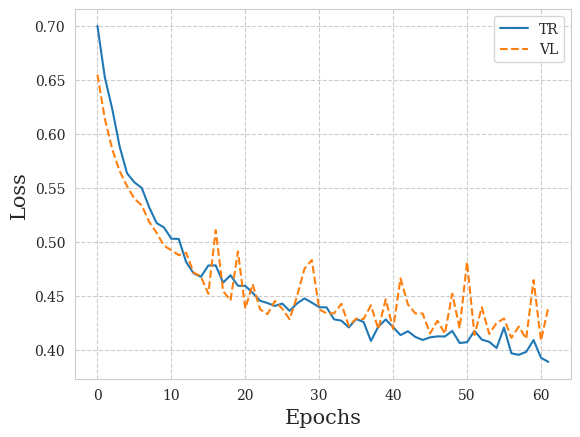

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82       296
         1.0       0.89      0.59      0.71       253

    accuracy                           0.78       549
   macro avg       0.81      0.77      0.77       549
weighted avg       0.80      0.78      0.77       549



In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(23)
model = Sequential()
model.add(Dense(128,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=62, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               50304     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 58,625
Trainable params: 58,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/62
58/58 [==============================] - 

In [ ]:
# performance on test
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       336
         1.0       0.77      0.75      0.76       288

    accuracy                           0.78       624
   macro avg       0.78      0.78      0.78       624
weighted avg       0.78      0.78      0.78       624



20/20 [==============================] - 0s 2ms/step


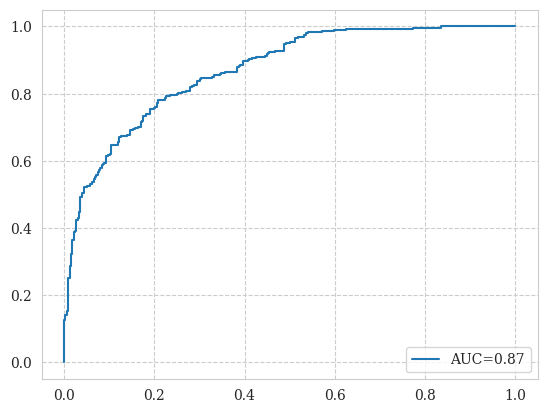

In [ ]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

In [ ]:
fpr_emo_int = fpr
tpr_emo_int = tpr
auc_emo_int = auc

In [ ]:
print(fpr_emo_int, "\n")
print(tpr_emo_int, "\n")
print(auc_emo_int)

[0.         0.         0.         0.00297619 0.00297619 0.00595238
 0.00595238 0.00892857 0.00892857 0.01190476 0.01190476 0.01488095
 0.01488095 0.01785714 0.01785714 0.02083333 0.02083333 0.02380952
 0.02380952 0.02678571 0.02678571 0.0297619  0.0297619  0.0327381
 0.0327381  0.03571429 0.03571429 0.03869048 0.03869048 0.04464286
 0.04464286 0.05059524 0.05059524 0.05654762 0.05654762 0.0625
 0.0625     0.06547619 0.06547619 0.06845238 0.06845238 0.07142857
 0.07142857 0.07440476 0.07440476 0.07738095 0.07738095 0.08035714
 0.08035714 0.08333333 0.08333333 0.08630952 0.08630952 0.08928571
 0.08928571 0.0922619  0.0922619  0.09821429 0.09821429 0.10119048
 0.10119048 0.10416667 0.10416667 0.11904762 0.11904762 0.12202381
 0.12202381 0.125      0.125      0.13988095 0.13988095 0.14583333
 0.14583333 0.15178571 0.15178571 0.1577381  0.1577381  0.16369048
 0.16369048 0.16964286 0.16964286 0.17261905 0.17261905 0.17559524
 0.17559524 0.18154762 0.18154762 0.19047619 0.19047619 0.19940476


####III

In [ ]:
# function to be passed to scikeras wrapper
def build_fn(n_hidden_units1, n_hidden_units2, hidden_activation, learning_rate, regularizer, initializer, output_activation, dropout_rate, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units1,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units2,
                    activation = hidden_activation,
                    kernel_initializer = initializer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,
                    activation = output_activation,
                    kernel_initializer = initializer))

    model.compile(optimizer = Adam(learning_rate = learning_rate),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "sigmoid",
                        regularizer=L2,
                        initializer="glorot_normal",
                        output_activation="sigmoid",
                        random_state=42,
                        batch_size=32,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units1': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [2, 4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.01, .001, .1, 1],
              'model__dropout_rate': [.2, .4, .6],
              'model__seed': random.sample(range(100), 100),
              'epochs': [10, 20, 50, 100, 200]
              }

search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(3, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best score: 0.7748164762711056 
Best params {'model__seed': 89, 'model__n_hidden_units2': 8, 'model__n_hidden_units1': 16, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 200}


In [ ]:
keras.backend.clear_session()
set_seed(89)
model = Sequential()
model.add(Dense(16,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(8,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6288      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Epoch 1/200
40/40 [==============================] - 2s 33ms/step - loss: 0.6967 - accuracy: 0.5614 - val_loss: 0.6760 - val_accuracy: 0.5701
Epoch 2/200
40/40 [==============================] - 0s 11ms/step - loss: 0.6827 - accuracy: 0.5622 - val_loss: 0.6628 - val_accuracy: 0.6576
Epoch 3/200
40/40 [==============================] - 0s 7ms/step - loss: 0.6654 - accuracy: 0.6122 - val_loss: 0.6499 - val_accuracy: 0.6885
Epoch 4/200
40/40 [==============================] - 0s 5ms/step - loss: 0.6566 - accuracy: 0.6247 - val_loss: 0.6370 - val_accuracy: 0.6885
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6359 - accuracy: 0.6529 - val_loss: 0.6262 - val_accuracy: 0.6831
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6323 - accuracy: 0.6497 - val_loss: 0.6130 - val_accuracy: 0.6958
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.6226 - accuracy: 0.6685 - val_loss: 0.6041 - val_accuracy: 0.7086
Epoch 8/200

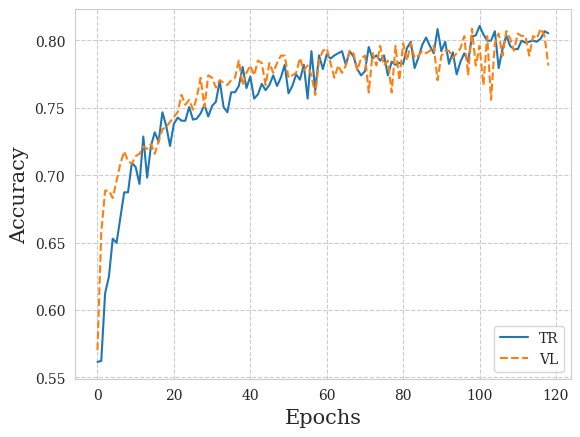

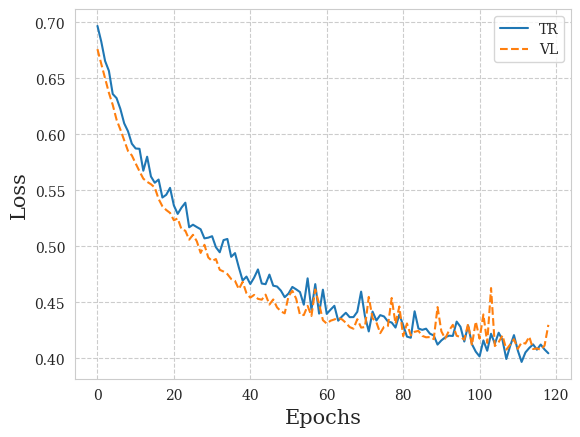

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_sigmoid(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82       296
         1.0       0.90      0.59      0.71       253

    accuracy                           0.78       549
   macro avg       0.81      0.77      0.77       549
weighted avg       0.81      0.78      0.77       549



In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(89)
model = Sequential()
model.add(Dense(16,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(8,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6288      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


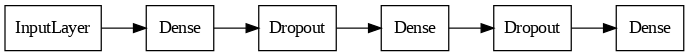

In [ ]:
plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    expand_nested=False,
    dpi=90,
    rankdir='LR',
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(89)
model = Sequential()
model.add(Dense(16,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(8,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
model.summary()

history = model.fit(X_train, y_train, epochs=118, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                6288      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/118
58/58 [==============================] - 2

In [ ]:
# performance on test
y_pred = get_pred_sigmoid(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.79       336
         1.0       0.74      0.81      0.77       288

    accuracy                           0.78       624
   macro avg       0.78      0.78      0.78       624
weighted avg       0.78      0.78      0.78       624



20/20 [==============================] - 0s 6ms/step


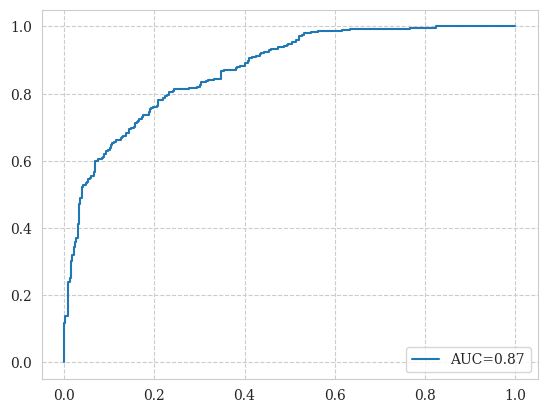

In [ ]:
# ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

In [ ]:
fpr_emo_int = fpr
tpr_emo_int = tpr
auc_emo_int = auc

In [ ]:
print(fpr_emo_int, "\n")
print(tpr_emo_int, "\n")
print(auc_emo_int)

[0.         0.         0.         0.00297619 0.00297619 0.00892857
 0.00892857 0.01190476 0.01190476 0.01488095 0.01488095 0.01785714
 0.01785714 0.02083333 0.02083333 0.02380952 0.02380952 0.02678571
 0.02678571 0.0297619  0.0297619  0.0327381  0.0327381  0.03571429
 0.03571429 0.03869048 0.03869048 0.04166667 0.04166667 0.04761905
 0.04761905 0.05059524 0.05059524 0.05357143 0.05357143 0.05654762
 0.05654762 0.05952381 0.05952381 0.06547619 0.06547619 0.06845238
 0.06845238 0.07440476 0.07440476 0.08333333 0.08333333 0.08630952
 0.08630952 0.08928571 0.08928571 0.0922619  0.0922619  0.09821429
 0.09821429 0.10119048 0.10119048 0.10416667 0.10416667 0.10714286
 0.10714286 0.11011905 0.11011905 0.11607143 0.11607143 0.125
 0.125      0.12797619 0.12797619 0.13095238 0.13095238 0.13690476
 0.13690476 0.14285714 0.14285714 0.14880952 0.14880952 0.1547619
 0.1547619  0.1577381  0.1577381  0.16071429 0.16071429 0.16369048
 0.16369048 0.16666667 0.16666667 0.17261905 0.17261905 0.17559524
 

#### Retraining on 10 random weight initalizations

In [ ]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(16,
                activation = 'sigmoid',
                input_shape = (X_train.shape[1],),
                kernel_initializer = 'glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(8,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1,
                activation = 'sigmoid',
                kernel_initializer = 'glorot_uniform'))

    model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

    model.fit(X_train, y_train, epochs=118, batch_size=32, verbose=0)
    y_pred = get_pred_sigmoid(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 4/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 5/10
20/20 [==============================] - 0s 1ms/step
Random weight initialization 6/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 7/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 8/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 9/10
20/20 [==============================] - 0s 2ms/step
Random weight initialization 10/10
20/20 [==============================] - 0s 2ms/step

Avg Accuracy: 0.7714743589743589 Std Accuracy: 0.008812645567222775
Avg Wt. F1: 0.7710451297010577 Std Wt. F1: 0.008812645567222

###**Target: Emotion**

#### Alternative Scaling

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/df_train_processed.csv')
df_test = pd.read_csv('/content/drive/My Drive/df_test_processed.csv')

In [ ]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [ ]:
# standardization (train)
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = StandardScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [ ]:
# standardization (test)
df_test_num = df_test.select_dtypes(include="number").drop("actor", axis=1)
df_test_cat = df_test.select_dtypes(include=['object'])

scaler = StandardScaler()
df_test_num_scaled = pd.DataFrame(scaler.fit_transform(df_test_num), columns=df_test_num.columns)
df_test = pd.concat([df_test_num_scaled, df_test_cat], axis=1)

In [ ]:
print(df_train.shape, df_test.shape)

(1828, 382) (624, 382)


#### Data Preparation

In [ ]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "calm":
      new_array[i] = 1
    elif array[i] == "happy":
      new_array[i] = 2
    elif array[i] == "sad":
      new_array[i] = 3
    elif array[i] == "angry":
      new_array[i] = 4
    elif array[i] == "fearful":
      new_array[i] = 5
    elif array[i] == "disgust":
      new_array[i] = 6
    elif array[i] == "surprised":
      new_array[i] = 7
  return new_array

In [ ]:
X_test = df_test.drop("emotion", axis=1)
X_test = pd.get_dummies(X_test)
X_test.head(10)

,frame_count,sum,mean,std,min,max,q01,q05,q25,q50,...,vocal_channel_song,vocal_channel_speech,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M
0,-1.392799,0.374478,0.471300,-0.815051,0.777164,-0.786709,0.779041,0.821105,0.677448,0.040064,...,0,1,1,0,0,1,1,0,0,1
1,-1.615684,0.096097,0.126584,-0.823277,0.768200,-0.778866,0.797439,0.834223,0.659627,0.040064,...,0,1,1,0,0,1,0,1,0,1
2,-1.448529,-0.467334,-0.591735,-0.829775,0.818882,-0.832860,0.799074,0.821105,0.695268,0.040064,...,0,1,1,0,1,0,1,0,0,1
3,-1.504259,-0.060947,-0.077100,-0.794667,0.717862,-0.776905,0.766368,0.805363,0.677448,0.040064,...,0,1,1,0,1,0,0,1,0,1
4,-0.891368,0.121215,0.141006,-0.900947,0.871633,-0.881877,0.864896,0.905935,0.695268,0.040064,...,0,1,1,0,0,1,1,0,0,1
5,-0.891368,-0.175641,-0.201282,-0.889667,0.858015,-0.884592,0.850587,0.897189,0.677448,0.040064,...,0,1,1,0,0,1,0,1,0,1
6,-1.448529,-0.800589,-1.014419,-0.872695,0.844396,-0.834368,0.835460,0.877075,0.677448,0.040064,...,0,1,1,0,1,0,1,0,0,1
7,-1.225679,-0.451919,-0.550041,-0.889292,0.840431,-0.838290,0.858355,0.892817,0.677448,0.040064,...,0,1,1,0,1,0,0,1,0,1
8,0.445838,-1.028232,-0.971596,-0.806992,0.816124,-0.841909,0.761462,0.785249,0.588344,0.040064,...,0,1,0,1,0,1,1,0,0,1
9,-0.278478,-1.333070,-1.395903,-0.832619,0.814917,-0.787312,0.795395,0.838596,0.623985,0.040064,...,0,1,0,1,0,1,0,1,0,1


In [ ]:
X_train = df_train.drop("emotion", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_train = label_encoder(df_train["emotion"]) # -9, -10

In [ ]:
X_test = df_test.drop("emotion", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_test = label_encoder(df_test["emotion"])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 386) (1828,)
(624, 386) (624,)


In [ ]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=10)

In [ ]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 386) (1462,)
(366, 386) (366,)


####I

In [ ]:
# function to be passed to scikeras wrapper

def build_fn(n_hidden_units1, n_hidden_units2, n_hidden_units3, hidden_activation, learning_rate, initializer, output_activation, dropout_rate, seed):
    keras.backend.clear_session()
    set_seed(seed)
    model = Sequential()
    model.add(Dense(n_hidden_units1,
                    activation = hidden_activation,
                    input_shape = (X_train.shape[1],),
                    kernel_initializer = initializer,
                    )
    )
    model.add(Dense(n_hidden_units2,
                    activation = hidden_activation,
                    kernel_initializer = initializer,
                    )
    )
    model.add(Dense(n_hidden_units3,
                    activation = hidden_activation,
                    kernel_initializer = initializer,
                    )
    )
    model.add(Dropout(dropout_rate))
    model.add(Dense(8,
                    activation = output_activation,
                    kernel_initializer = initializer,
                    )
    )

    model.compile(optimizer = Adam(learning_rate),
                  loss = SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model

In [ ]:
# randomized search
model = KerasClassifier(build_fn,
                        hidden_activation = "relu",
                        initializer="he_normal",
                        output_activation="softmax",
                        random_state=42,
                        verbose=0
                        )

param_grid = {'model__n_hidden_units1': [4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units2': [4, 8, 16, 32, 64, 128, 256],
              'model__n_hidden_units3': [4, 8, 16, 32, 64, 128, 256],
              'model__learning_rate': [.0001, .001, .01, .1, 1],
              'model__dropout_rate': [.2, .3, .4, .5, .6, .7],
              'model__seed': random.sample(range(100), 100),
              'epochs': [100, 200, 300, 400, 500],
              }


search = RandomizedSearchCV(model,
                            param_grid,
                            cv=StratifiedKFold(3, shuffle=True, random_state=42),
                            verbose=1,
                            n_iter=50,
                            n_jobs=-1,
                            scoring='accuracy',
                            error_score='raise')

search.fit(X_train2, y_train2, verbose=0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: ignored

In [ ]:
keras.backend.clear_session()
set_seed(43)

model = Sequential()
model.add(Dense(256,
                activation = "sigmoid",
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.001)

                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.0001)
                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.0001)))
))
model.add(Dropout(0.4))

model.add(Dense(8,
                activation = "softmax",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(0.0001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)

history = model.fit(X_train2, y_train2, epochs=400, batch_size=32, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               99072     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 232,712
Trainable params: 232,712
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
46/46 [==============================]

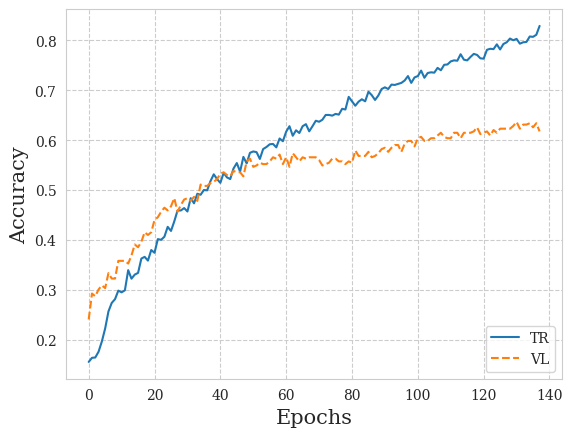

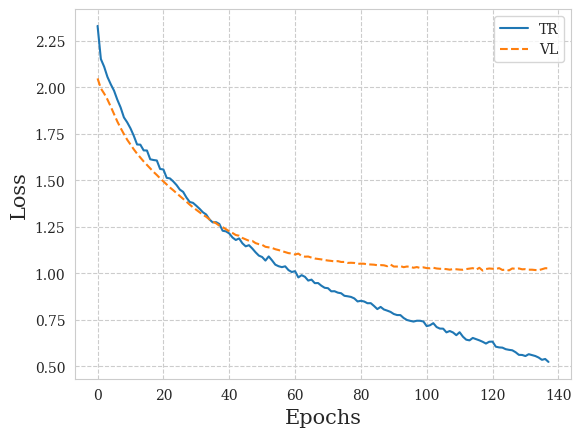

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_softmax(model.predict(X_val))
print(classification_report(y_val, y_pred))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.42      0.29      0.34        28
         1.0       0.59      0.70      0.64        56
         2.0       0.64      0.48      0.55        56
         3.0       0.49      0.59      0.54        56
         4.0       0.78      0.84      0.81        56
         5.0       0.73      0.71      0.72        56
         6.0       0.52      0.48      0.50        29
         7.0       0.60      0.62      0.61        29

    accuracy                           0.62       366
   macro avg       0.60      0.59      0.59       366
weighted avg       0.62      0.62      0.61       366



In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(43)

model = Sequential()
model.add(Dense(256,
                activation = "sigmoid",
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_uniform",
                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_uniform",

                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_uniform",
))
model.add(Dropout(0.4))

model.add(Dense(8,
                activation = "softmax",
                kernel_initializer = "glorot_uniform"))

model.compile(optimizer = Adam(0.0001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=138, batch_size=32, verbose=0) #290

In [ ]:
# performance on test with only train2
y_pred = get_pred_softmax(model.predict(X_test)) # 138 epochs
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.52      0.54        48
         1.0       0.56      0.72      0.63        96
         2.0       0.49      0.40      0.44        96
         3.0       0.44      0.35      0.39        96
         4.0       0.55      0.77      0.64        96
         5.0       0.65      0.46      0.54        96
         6.0       0.56      0.52      0.54        48
         7.0       0.40      0.44      0.42        48

    accuracy                           0.53       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.53      0.53      0.52       624



In [ ]:
# performance on test with only train2
y_pred = get_pred_softmax(model.predict(X_test)) #290 epochs
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.58        48
         1.0       0.60      0.70      0.64        96
         2.0       0.42      0.34      0.38        96
         3.0       0.42      0.36      0.39        96
         4.0       0.58      0.76      0.66        96
         5.0       0.58      0.43      0.49        96
         6.0       0.53      0.54      0.54        48
         7.0       0.48      0.56      0.52        48

    accuracy                           0.53       624
   macro avg       0.52      0.54      0.52       624
weighted avg       0.52      0.53      0.52       624



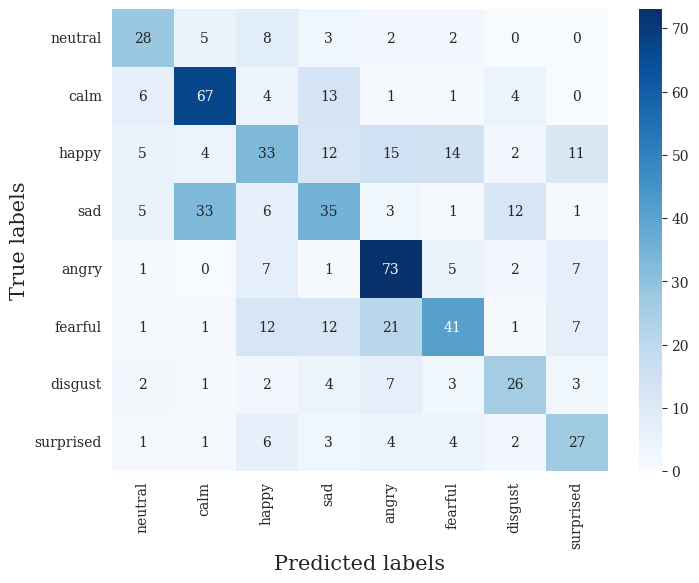

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xticklabels(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
ax.set_yticklabels(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

#### Testing su binarie

In [ ]:
def label_encoder(array):
    new_array = []
    for item in array:
        if item == "calm":
          new_array.append(1)
        elif item == "happy":
          new_array.append(2)
        elif item == "sad":
          new_array.append(3)
        elif item == "angry":
          new_array.append(4)
        elif item == "fearful":
          new_array.append(5)
        elif item == "disgust":
          new_array.append(6)
        elif item == "surprised":
          new_array.append(7)
        elif item == "neutral":
          new_array.append(0)
    return np.array(new_array)

In [ ]:
# providing separate metrics for speech and song
X_test_new = df_test.drop("emotion", axis=1)
X_test_new = pd.get_dummies(X_test_new)
X_test_new['emotion'] = df_test['emotion']

X_test_speech = X_test_new[X_test_new['emotional_intensity_strong'] == 1]
#X_test_speech = X_test_speech.reindex(range(0, len(X_test_speech)))
y_test_speech = label_encoder(X_test_speech['emotion'])
X_test_speech = X_test_speech.drop('emotion', axis=1)

X_test_song = X_test_new[X_test_new['emotional_intensity_normal'] == 1]
#X_test_song = X_test_song.reindex(range(0, len(X_test_song)))
y_test_song = label_encoder(X_test_song['emotion'])
X_test_song = X_test_song.drop('emotion', axis=1)

X_test_speech = X_test_speech.to_numpy()
X_test_song = X_test_song.to_numpy()

In [ ]:
print(X_test.shape, y_test.shape)
print(X_test_speech.shape, y_test_speech.shape)
print(X_test_song.shape, y_test_song.shape)

(624, 386) (624,)
(288, 386) (288,)
(336, 386) (336,)


In [ ]:
y_pred = get_pred_softmax(model.predict(X_test_speech)) # much more accurate if emotional_intensity == strong
print(classification_report(y_test_speech, y_pred))

9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       0.69      0.83      0.75        48
           2       0.48      0.29      0.36        48
           3       0.50      0.40      0.44        48
           4       0.68      0.90      0.77        48
           5       0.71      0.50      0.59        48
           6       0.50      0.67      0.57        24
           7       0.56      0.79      0.66        24

    accuracy                           0.61       288
   macro avg       0.59      0.62      0.59       288
weighted avg       0.60      0.61      0.59       288



In [ ]:
y_pred = get_pred_softmax(model.predict(X_test_song))
print(classification_report(y_test_song, y_pred))

11/11 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.58      0.58        48
           1       0.50      0.56      0.53        48
           2       0.39      0.40      0.39        48
           3       0.36      0.33      0.34        48
           4       0.48      0.62      0.54        48
           5       0.46      0.35      0.40        48
           6       0.59      0.42      0.49        24
           7       0.36      0.33      0.35        24

    accuracy                           0.46       336
   macro avg       0.46      0.45      0.45       336
weighted avg       0.46      0.46      0.46       336



In [ ]:
# providing separate metrics for speech and song
X_test_new = df_test.drop("emotion", axis=1)
X_test_new = pd.get_dummies(X_test_new)
X_test_new['emotion'] = df_test['emotion']

X_test_speech = X_test_new[X_test_new['sex_M'] == 1]
#X_test_speech = X_test_speech.reindex(range(0, len(X_test_speech)))
y_test_speech = label_encoder(X_test_speech['emotion'])
X_test_speech = X_test_speech.drop('emotion', axis=1)

X_test_song = X_test_new[X_test_new['sex_F'] == 1]
#X_test_song = X_test_song.reindex(range(0, len(X_test_song)))
y_test_song = label_encoder(X_test_song['emotion'])
X_test_song = X_test_song.drop('emotion', axis=1)

X_test_speech = X_test_speech.to_numpy()
X_test_song = X_test_song.to_numpy()

In [ ]:
print(X_test.shape, y_test.shape)
print(X_test_speech.shape, y_test_speech.shape)
print(X_test_song.shape, y_test_song.shape)

(624, 386) (624,)
(312, 386) (312,)
(312, 386) (312,)


In [ ]:
y_pred = get_pred_softmax(model.predict(X_test_speech))
print(classification_report(y_test_speech, y_pred))

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.61      0.46      0.52        24
           1       0.57      0.65      0.61        48
           2       0.39      0.33      0.36        48
           3       0.42      0.27      0.33        48
           4       0.48      0.83      0.61        48
           5       0.58      0.38      0.46        48
           6       0.37      0.42      0.39        24
           7       0.42      0.46      0.44        24

    accuracy                           0.48       312
   macro avg       0.48      0.47      0.46       312
weighted avg       0.48      0.48      0.47       312



In [ ]:
y_pred = get_pred_softmax(model.predict(X_test_song)) # more precise on women
print(classification_report(y_test_song, y_pred))

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.55      0.71      0.62        24
           1       0.62      0.75      0.68        48
           2       0.46      0.35      0.40        48
           3       0.42      0.46      0.44        48
           4       0.79      0.69      0.73        48
           5       0.57      0.48      0.52        48
           6       0.73      0.67      0.70        24
           7       0.53      0.67      0.59        24

    accuracy                           0.58       312
   macro avg       0.58      0.60      0.59       312
weighted avg       0.58      0.58      0.57       312



In [ ]:
# old model
keras.backend.clear_session()
set_seed(43)

model = Sequential()
model.add(Dense(256,
                activation = "sigmoid",
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.001)

                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.0001)
                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
                #kernel_regularizer = L1(0.0001)))
))
model.add(Dropout(0.4))

model.add(Dense(8,
                activation = "softmax",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(0.0001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=20, verbose=True)
history = model.fit(X_train2, y_train2, epochs=500, batch_size=100, validation_data=(X_val, y_val), callbacks=[es], verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               28416     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 162,056
Trainable params: 162,056
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
13/13 [==============================]

KeyboardInterrupt: ignored

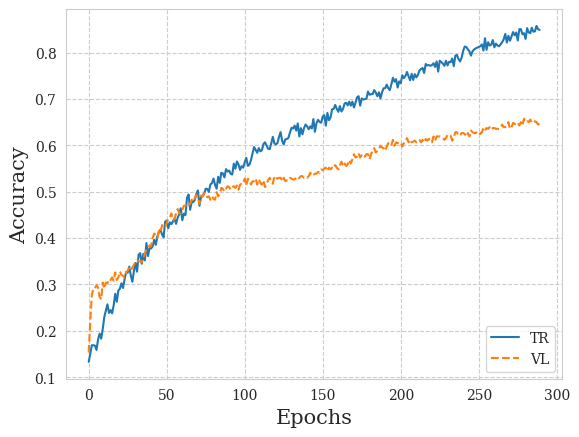

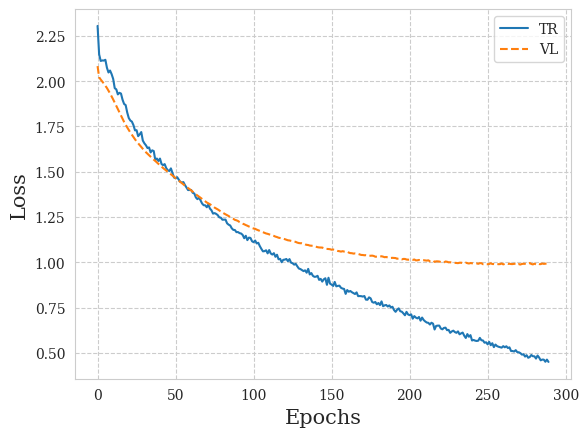

In [ ]:
plot_acc_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [ ]:
# performance on validation
y_pred = get_pred_softmax(model.predict(X_val))
print(classification_report(y_val, y_pred))

18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.47      0.57      0.52        42
         1.0       0.64      0.69      0.66        84
         2.0       0.67      0.57      0.62        84
         3.0       0.55      0.50      0.52        84
         4.0       0.76      0.85      0.80        84
         5.0       0.78      0.75      0.76        84
         6.0       0.63      0.59      0.61        44
         7.0       0.56      0.56      0.56        43

    accuracy                           0.65       549
   macro avg       0.63      0.63      0.63       549
weighted avg       0.65      0.65      0.65       549



In [ ]:
# retrain on all data (X_train)
keras.backend.clear_session()
set_seed(43)

model = Sequential()
model.add(Dense(256,
                activation = "sigmoid",
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal",
                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",

                )
          )
model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
))
model.add(Dropout(0.4))

model.add(Dense(8,
                activation = "softmax",
                kernel_initializer = "glorot_normal"))

model.compile(optimizer = Adam(0.0001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ["accuracy"])

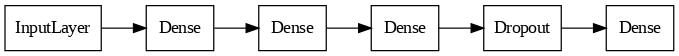

In [ ]:
plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    expand_nested=False,
    dpi=90,
    rankdir='LR',
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=290, verbose=0)

In [ ]:
# performance on test with only train2
y_pred = get_pred_softmax(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.39      0.40      0.39        48
         1.0       0.47      0.77      0.58        96
         2.0       0.47      0.38      0.42        96
         3.0       0.28      0.17      0.21        96
         4.0       0.58      0.78      0.67        96
         5.0       0.67      0.32      0.44        96
         6.0       0.52      0.60      0.56        48
         7.0       0.44      0.46      0.45        48

    accuracy                           0.48       624
   macro avg       0.48      0.48      0.46       624
weighted avg       0.48      0.48      0.46       624



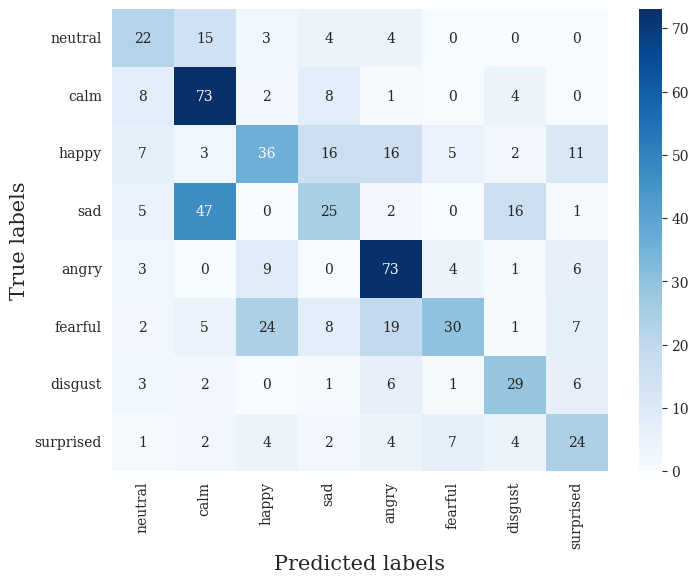

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xticklabels(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
ax.set_yticklabels(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

#### Retraining on 10 random weight initalizations

In [ ]:
accs = []
f1s = []
iter = 1
for i in random.sample(range(100), 10):
    print(f"Random weight initialization {iter}/10")
    keras.backend.clear_session()
    tf.random.set_seed(i)

    model = Sequential()
    model.add(Dense(256,
                activation = "sigmoid",
                input_shape = (X_train.shape[1],),
                kernel_initializer = "glorot_normal",
                )
          )
    model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",

                )
          )
    model.add(Dense(256,
                activation = "sigmoid",
                kernel_initializer = "glorot_normal",
    ))
    model.add(Dropout(0.4))

    model.add(Dense(8,
                activation = "softmax",
                kernel_initializer = "glorot_normal"))

    model.compile(optimizer = Adam(0.0001),
               loss = SparseCategoricalCrossentropy(),
               metrics = ["accuracy"])

    model.fit(X_train, y_train, epochs=290, batch_size=32, verbose=0)
    y_pred = get_pred_softmax(model.predict(X_test))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(i, acc, f1)
    accs.append(acc)
    f1s.append(f1)
    iter += 1

print(f"\nAvg Accuracy: {np.mean(accs)}", f"Std Accuracy: {np.std(accs)}")
print(f"Avg Wt. F1: {np.mean(f1s)}", f"Std Wt. F1: {np.std(accs)}")

Random weight initialization 1/10
20/20 [==============================] - 0s 3ms/step
78 0.532051282051282 0.5222444838051432
Random weight initialization 2/10
20/20 [==============================] - 0s 2ms/step
77 0.5240384615384616 0.5118109018888574
Random weight initialization 3/10
20/20 [==============================] - 0s 2ms/step
86 0.530448717948718 0.5211168298234866
Random weight initialization 4/10
20/20 [==============================] - 0s 4ms/step
7 0.5 0.4913082590573731
Random weight initialization 5/10
20/20 [==============================] - 0s 2ms/step
74 0.5176282051282052 0.5050735363032812
Random weight initialization 6/10
20/20 [==============================] - 0s 2ms/step
96 0.5128205128205128 0.5040210547909233
Random weight initialization 7/10
20/20 [==============================] - 0s 3ms/step
88 0.5144230769230769 0.5033235851345903
Random weight initialization 8/10
20/20 [==============================] - 0s 4ms/step
59 0.5224358974358975 0.51335038695